In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import random
%load_ext autoreload
%autoreload 2

### Generation of the data

In [2]:
Npoints = 100000
sigma_x = np.sqrt(1/2)
sigma_z = np.sqrt(1/2)

# torch works with float32
x = np.exp(sigma_x * np.random.randn(Npoints))
z = np.log(x) + sigma_z * np.random.randn(Npoints)

x_torch = torch.as_tensor(x.astype('float32')).reshape((-1,1))

In [33]:
Npoints = 100000
k = 3; # number of modes
n = int(Npoints/k) * np.ones(k).astype('int')
n[-1] += Npoints - np.sum(n)
x = []
for j in range(k):
    array = 0.1*np.random.randn(n[j],1)-(0.5+j-k/2)
    print(array.shape)
    x.append(array)

x = np.vstack(x).ravel()
print(x.shape)
x_torch = torch.as_tensor(x.astype('float32')).reshape((-1,1))
x_torch.shape

(33333, 1)
(33333, 1)
(33334, 1)
(100000,)


torch.Size([100000, 1])

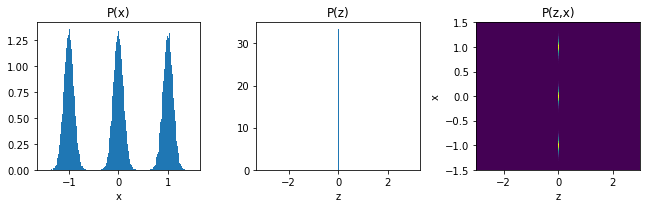

In [34]:
def plot_histograms(x, z, nbins=50, xy_range = 3, z_range=3):
    fig = plt.figure(figsize=(9,3))
    plt.subplot(131)
    plt.hist(x, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('x')
    plt.title('P(x)')
    plt.subplot(132)
    plt.hist(z, bins=nbins, density = True, range=(-z_range,z_range));
    plt.xlabel('z')
    plt.title('P(z)')
    plt.subplot(133)
    counts, xbins, ybins = np.histogram2d(z, x, bins=(nbins, nbins), density=True, range=((-z_range,z_range),(-xy_range,xy_range)))
    counts = counts.T
    plt.pcolormesh(xbins, ybins, counts)
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title('P(z,x)')
    plt.tight_layout()
plot_histograms(x,x*0,200,xy_range=1.5)

# Variational inference (VI)
Define parametric approximations for encoder and decoder: <br>
<center> $P(z|x) \to q_{\phi}(z|x)$ and $P(x|z) \to q_{\theta}(x|z)$ </center>
Specify explicit form of encoder and decoder with Neural networks:
$$q_{\phi}(z|x) =\mathcal{N}(g(x),h(x))$$
$$q_{\theta}(x|z)=\mathcal{N}(f(z),c(z))$$
where $h(x)$ and $c(z)$ - variances.
Then Loss function:
$$L_{VAE}(x_i) = \frac{1}{2} \mathbb{E}_{z \sim \mathcal{N}(g(x_i),h(x_i))} \left[ \log c(z) + \frac{(x_i - f(z))^2}{c(z)} \right] + D_{KL}(\mathcal{N}(g(x_i),h(x_i)), \mathcal{N}(0,1))$$
Last approximation - change expectation with 1 Monte-Carlo sample (https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73):
$$L_{VAE}(x_i) = \frac{1}{2} \log c(z) + \frac{(x_i - f(z_i))^2}{2c(z)} + \left[ - \frac{1}{2} \log h(x_i) + \frac{h(x_i) + (g(x_i))^2}{2} - \frac{1}{2} \right]$$
$$z_i = g(x_i) + \xi \sqrt{h(x_i)}, \xi \sim \mathcal{N}(0,1)$$

In [76]:
class Net(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        
        encoder_blocks = []
        encoder_blocks.extend([nn.Linear(1,width), nn.ReLU(), nn.BatchNorm1d(width)])
        for j in range(depth-2):
            encoder_blocks.extend([nn.Linear(width,width), nn.ReLU(), nn.BatchNorm1d(width)])
        encoder_blocks.append(nn.Linear(width,2))
        
        self.encoder = nn.Sequential(*encoder_blocks)
        
        decoder_blocks = []
        decoder_blocks.extend([nn.Linear(1,width), nn.ReLU(), nn.BatchNorm1d(width)])
        for j in range(depth-2):
            decoder_blocks.extend([nn.Linear(width,width), nn.ReLU(), nn.BatchNorm1d(width)])
        decoder_blocks.append(nn.Linear(width,2))
        
        self.decoder = nn.Sequential(*decoder_blocks)
    
    def forward(self, x):
        z = self.encoder(x)
        
        mean_z = z[:,0:1]
        var_z = nn.functional.softplus(z[:,1:2])
        
        z_sample = mean_z + torch.sqrt(var_z) * torch.randn(var_z.shape)
        
        y = self.decoder(z_sample)
        mean_x = y[:,0:1]
        var_x = nn.functional.softplus(y[:,1:2])
        #var_x = 1*torch.ones_like(mean_x)
        return mean_x, var_x, mean_z, var_z
    
    def generate_data(self, x):
        with torch.no_grad():
            self.eval()
            N = x.shape[0]
            # generate outputs
            z_gen = torch.randn(N,1)
            x_gen = self.decoder(z_gen)[:,0:1]
            
            # generate aggregated posterior and reconstruction
            z = self.encoder(x)
            mean_z = z[:,0:1]
            var_z = nn.functional.softplus(z[:,1:2])
            z_recon = mean_z + torch.sqrt(var_z) * torch.randn(var_z.shape)
            x_recon = self.decoder(z_recon)[:,0:1]
            
            return z_recon.numpy().squeeze(), x_recon.numpy().squeeze(), z_gen.numpy().squeeze(), x_gen.numpy().squeeze()
    def channels(self, xx, zz):
        with torch.no_grad():
            z = self.encoder(xx)
            mean_z = z[:,0:1]
            var_z = nn.functional.softplus(z[:,1:2])

            y = self.decoder(zz)
            mean_x = y[:,0:1]
            var_x = nn.functional.softplus(y[:,1:2])
            return mean_x, var_x, mean_z, var_z

In [77]:
def minibatch(x, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yield xx

In [78]:
# can be used for scalars, as well as for vectors
def KL(mu1,v1,mu2,v2):
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    var1 = torch.max(v1,torch.ones_like(v1)*1e-6)
    var2 = torch.max(v2,torch.ones_like(v2)*1e-6)
    out = 0.5*(torch.log(var2/var1) + (var1+torch.square(mu1-mu2))/var2-1)
    return out

In [79]:
# error per element
# https://ieeexplore.ieee.org/document/6289001, 
# formula 18
# loss compared to N(0,1)
def WGMM_loss(mean_z, var_z, diff_full = True):
    # number of elements in a mixture
    # is the batch size
    n = mean_z.shape[0]
    
    term0 = KL(mean_z, var_z, torch.tensor(0.), torch.tensor(1.))
    
    term1 = torch.zeros(n,1)
    for i in range(n):
        if diff_full:
            term1[i] = torch.log(torch.exp(-KL(mean_z[i],var_z[i],mean_z,var_z)).mean())
        else:
            term1[i] = torch.log(torch.exp(-KL(mean_z[i],var_z[i],mean_z.detach(),var_z.detach())).mean())
        
    return term0 + term1

mz = torch.randn(3000,1)
vz = 0.0001*torch.ones(3000,1)
print(WGMM_loss(mz,vz).mean())
print(KL(mz,vz,torch.tensor(0.), torch.tensor(1.)).mean())

tensor(-0.4414)
tensor(4.5851)


In [80]:
def criterion(true_x, mean_x, var_x, mean_z, var_z, regularize):
    error_gauss = 0.5 * (torch.log(var_x) + torch.square(true_x-mean_x) / var_x)
    if regularize == 'VAE':
        error_reg = 0.5*((var_z + torch.square(mean_z)) - torch.log(var_z) - 1)
    elif regularize == 'WGMM':
        error_reg = WGMM_loss(mean_z, var_z, diff_full=False)    
    elif regularize == 'AE':
        error_reg = error_gauss * 0
        
    error = error_gauss + error_reg
    
    n = error.shape[0]
    with torch.no_grad():
        error_sum = error.mean().item() * n
        
    return error.mean(), error_sum, n

In [81]:
from time import time
def train(net, x, lr=0.001, num_epochs=100, batch_size=64, regularize = 'VAE'):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    
    net.loss = {'VAE_loss': []}
    net.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_n = 0
        t = time()
        for xx in minibatch(x, batch_size):
            optimizer.zero_grad()
            mean_x, var_x, mean_z, var_z = net.forward(xx)
            loss, error, n = criterion(xx, mean_x, var_x, mean_z, var_z, regularize)
            loss.backward()
            optimizer.step()
            
            epoch_loss += error
            epoch_n += n
        net.loss['VAE_loss'].append(epoch_loss / epoch_n)
        scheduler.step()
        t = time() - t
        
        if epoch%10 == 0:
            print(f"epoch = {epoch+1}, numpoints = {epoch_n}, VAE_loss = {epoch_loss / epoch_n}, epoch time = {t}")

In [82]:
net = Net(100,1)

In [83]:
train(net, x_torch, batch_size = 2048, num_epochs=101, regularize='VAE')

epoch = 1, numpoints = 100000, VAE_loss = 0.3604888902568817, epoch time = 0.3213989734649658
epoch = 11, numpoints = 100000, VAE_loss = -0.19816238564491273, epoch time = 0.28571200370788574
epoch = 21, numpoints = 100000, VAE_loss = -0.30725071847915647, epoch time = 0.27857279777526855
epoch = 31, numpoints = 100000, VAE_loss = -0.3326580642604828, epoch time = 0.27944493293762207
epoch = 41, numpoints = 100000, VAE_loss = -0.3472710178279877, epoch time = 0.2789885997772217
epoch = 51, numpoints = 100000, VAE_loss = -0.38349362071990967, epoch time = 0.27771544456481934
epoch = 61, numpoints = 100000, VAE_loss = -0.38443974906921385, epoch time = 0.27805042266845703
epoch = 71, numpoints = 100000, VAE_loss = -0.39802704581260684, epoch time = 0.27956390380859375
epoch = 81, numpoints = 100000, VAE_loss = -0.3921212195301056, epoch time = 0.27720141410827637
epoch = 91, numpoints = 100000, VAE_loss = -0.40231071230888366, epoch time = 0.27750205993652344
epoch = 101, numpoints = 100

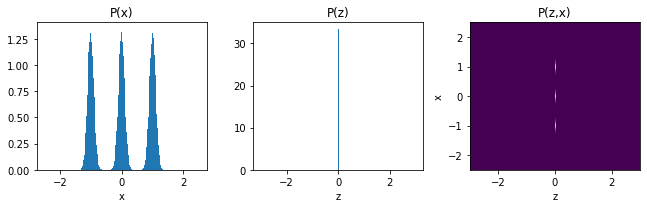

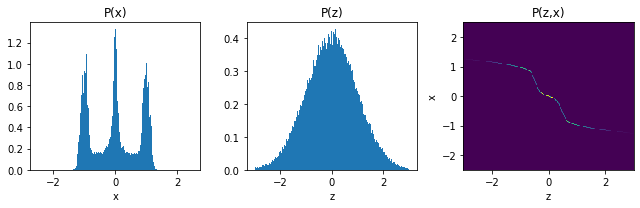

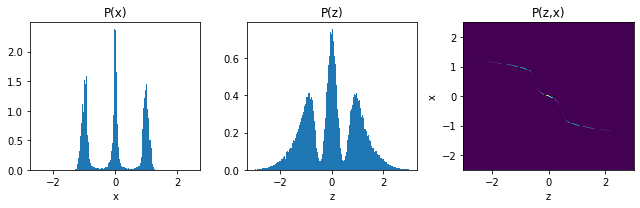

In [84]:
z_recon, x_recon, z_gen, x_gen = net.generate_data(x_torch)
plot_histograms(x,x*0,200,xy_range=2.5)
plot_histograms(x_gen, z_gen, 200, xy_range=2.5)
plot_histograms(x_recon, z_recon, 200, xy_range=2.5)

In [89]:
net = Net(100,1)

In [90]:
train(net, x_torch, batch_size = 64, num_epochs=101, regularize='WGMM')

epoch = 1, numpoints = 100000, VAE_loss = -0.9870777740657329, epoch time = 30.930779218673706
epoch = 11, numpoints = 100000, VAE_loss = -1.4810136958932876, epoch time = 29.922166347503662
epoch = 21, numpoints = 100000, VAE_loss = -1.5197873283553123, epoch time = 29.363056659698486
epoch = 31, numpoints = 100000, VAE_loss = -1.5441820184993744, epoch time = 29.46588969230652
epoch = 41, numpoints = 100000, VAE_loss = -1.568242252922058, epoch time = 29.583380460739136
epoch = 51, numpoints = 100000, VAE_loss = -1.6342827550768853, epoch time = 30.04344940185547
epoch = 61, numpoints = 100000, VAE_loss = -1.6469393528270722, epoch time = 30.471798181533813
epoch = 71, numpoints = 100000, VAE_loss = -1.6685840683841706, epoch time = 30.480160236358643
epoch = 81, numpoints = 100000, VAE_loss = -1.660241446404457, epoch time = 31.79466223716736
epoch = 91, numpoints = 100000, VAE_loss = -1.667694302520752, epoch time = 30.120179653167725
epoch = 101, numpoints = 100000, VAE_loss = -1.

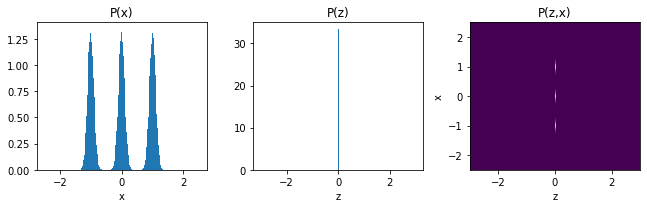

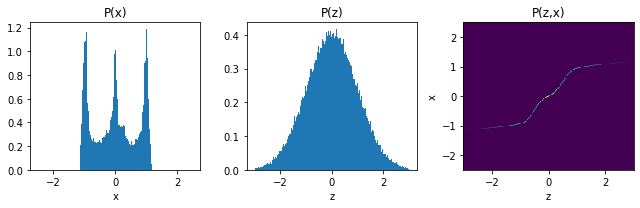

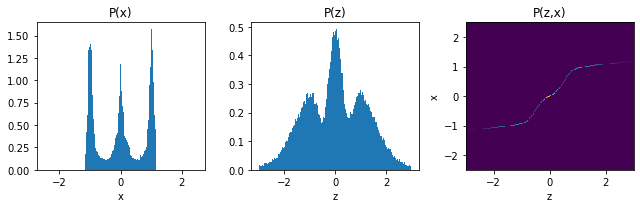

In [91]:
z_recon, x_recon, z_gen, x_gen = net.generate_data(x_torch)
plot_histograms(x,x*0,200,xy_range=2.5)
plot_histograms(x_gen, z_gen, 200, xy_range=2.5)
plot_histograms(x_recon, z_recon, 200, xy_range=2.5)

# WGMM optimization

In [103]:
n = 8
class Mixture(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n = n
        self.mu = nn.Parameter(1+1*torch.rand(n,1))
        self.pvar = nn.Parameter(-5*torch.ones(n,1))
    def generate(self,k):
        data = []
        var = nn.functional.softplus(self.pvar)
        for i in range(self.n):
            data.append(torch.randn(k) * torch.sqrt(var[i]) + self.mu[i])
        data = torch.cat(data, dim=0)
        return data.detach().numpy()
    def plot(self):
        def gauss(x, mu, var):
            return 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x-mu)**2/var)
        x=np.linspace(-3,3,200)
        y = 0*x
        var = nn.functional.softplus(self.pvar)
        for i in range(self.n):
            yy = gauss(x,self.mu[i].item(),var[i].item())/n
            y += yy
            plt.plot(x, yy,linewidth=0.5)
        plt.plot(x,y,'k',linewidth=2)
        plt.plot(x,gauss(x,0,1),'--k',linewidth=2)
m = Mixture(n)

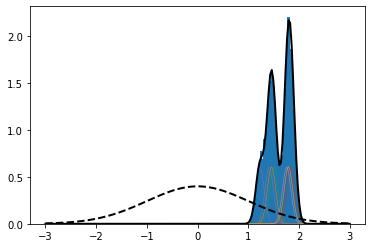

In [104]:
plt.hist(m.generate(1000), bins=200, density = True, range=(-3,3));
m.plot()

WGMM loss = 1.6750438213348389, KL loss = 2.9578051567077637
WGMM loss = 0.4396720826625824, KL loss = 2.300410747528076
WGMM loss = -0.1114109456539154, KL loss = 1.6490882635116577
WGMM loss = -0.42552489042282104, KL loss = 1.2623600959777832
WGMM loss = -0.5440879464149475, KL loss = 1.083551287651062
WGMM loss = -0.5888370871543884, KL loss = 0.9924978017807007
WGMM loss = -0.6173005700111389, KL loss = 0.9132289290428162
WGMM loss = -0.6324859857559204, KL loss = 0.8957939743995667
WGMM loss = -0.6348793506622314, KL loss = 0.8942034840583801
WGMM loss = -0.6352338790893555, KL loss = 0.8934458494186401


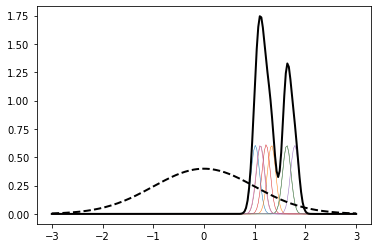

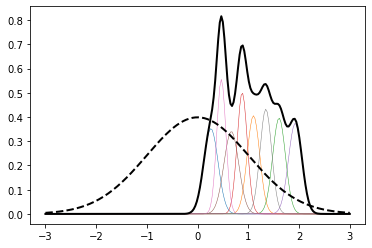

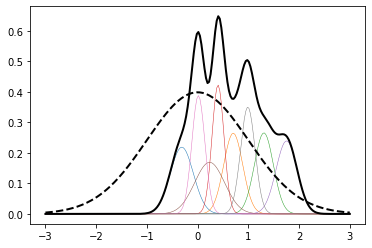

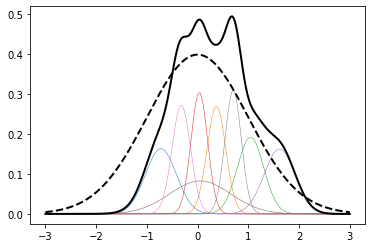

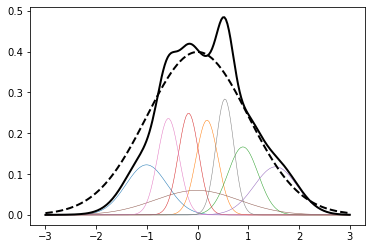

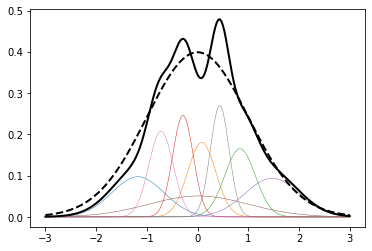

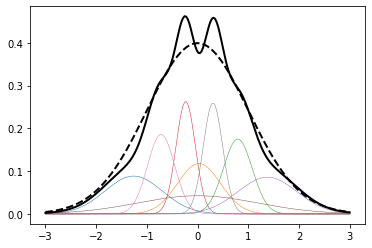

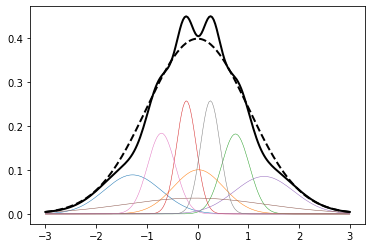

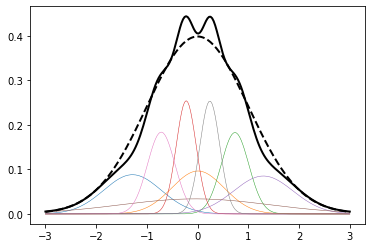

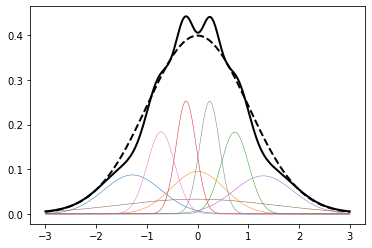

In [99]:
optimizer = optim.Adam(m.parameters(), lr=0.01)
for epoch in range(1000):
    optimizer.zero_grad()
    loss = WGMM_loss(m.mu,nn.functional.softplus(m.pvar)).mean()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'WGMM loss = {loss.item()}, KL loss = {KL(m.mu,nn.functional.softplus(m.pvar),torch.tensor(0.), torch.tensor(1.)).mean()}')
        plt.figure()
        m.plot()

WGMM loss = 1.6641273498535156, KL loss = 3.2096481323242188
WGMM loss = 0.36235910654067993, KL loss = 2.004636764526367
WGMM loss = -0.1494349092245102, KL loss = 1.3082420825958252
WGMM loss = -0.320296049118042, KL loss = 0.8927410840988159
WGMM loss = -0.33476337790489197, KL loss = 0.5999940633773804
WGMM loss = -0.2737174332141876, KL loss = 0.38646745681762695
WGMM loss = -0.1960957795381546, KL loss = 0.2447085827589035
WGMM loss = -0.13196009397506714, KL loss = 0.15636830031871796
WGMM loss = -0.08842653036117554, KL loss = 0.10310924053192139
WGMM loss = -0.06184447556734085, KL loss = 0.07171405106782913


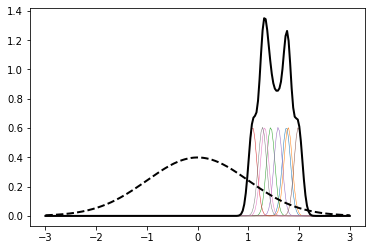

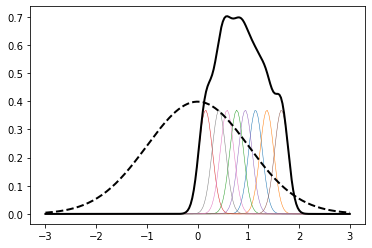

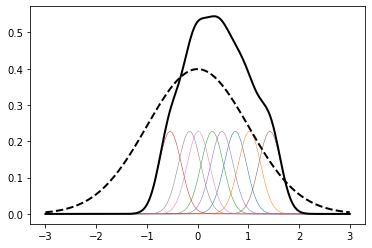

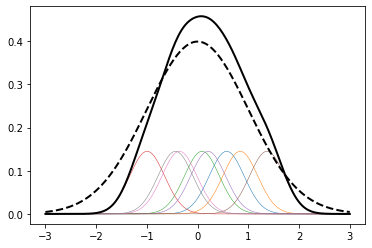

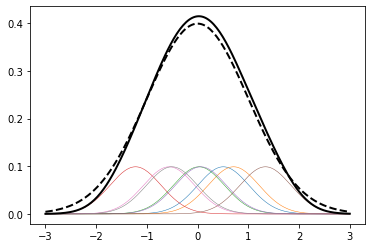

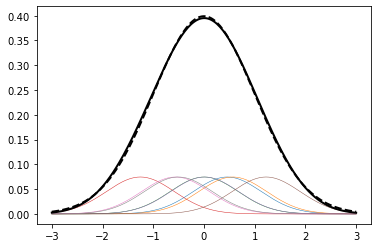

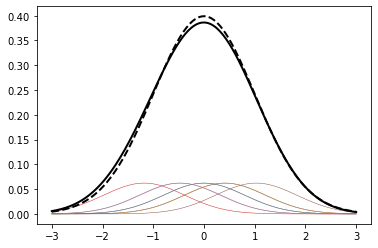

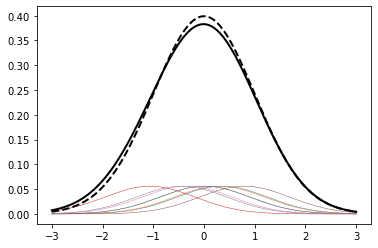

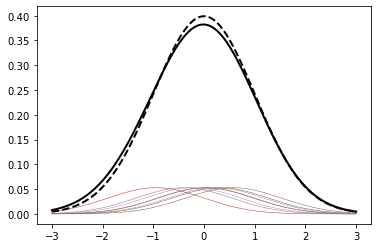

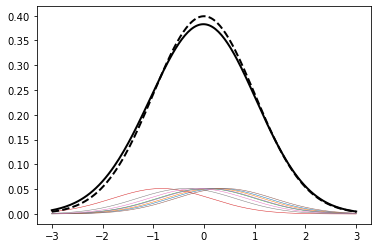

In [102]:
optimizer = optim.Adam(m.parameters(), lr=0.01)
for epoch in range(1000):
    optimizer.zero_grad()
    loss = WGMM_loss(m.mu,nn.functional.softplus(m.pvar),diff_full=False).mean()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'WGMM loss = {loss.item()}, KL loss = {KL(m.mu,nn.functional.softplus(m.pvar),torch.tensor(0.), torch.tensor(1.)).mean()}')
        plt.figure()
        m.plot()

KL loss = 3.2942049503326416
KL loss = 1.79397451877594
KL loss = 1.0794262886047363
KL loss = 0.629124641418457
KL loss = 0.3112972676753998
KL loss = 0.12549784779548645
KL loss = 0.042375609278678894
KL loss = 0.012454867362976074
KL loss = 0.0032398104667663574
KL loss = 0.0007456541061401367


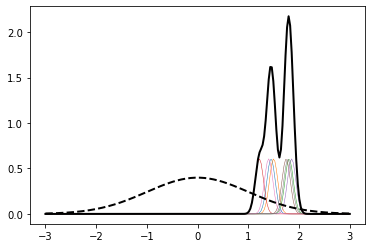

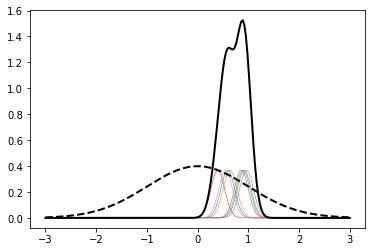

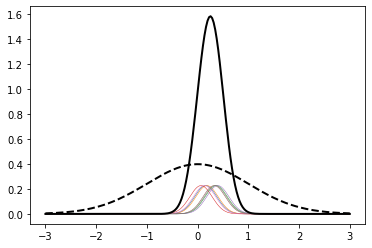

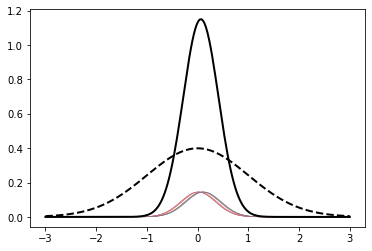

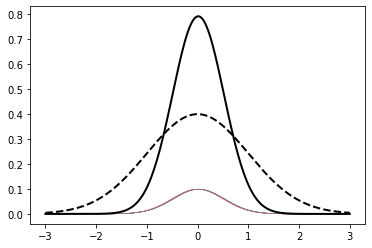

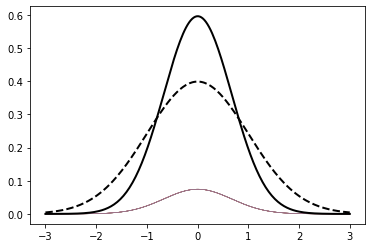

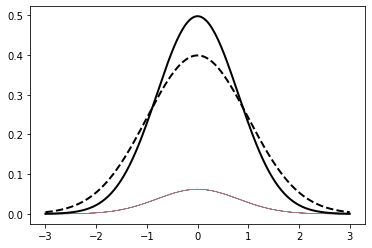

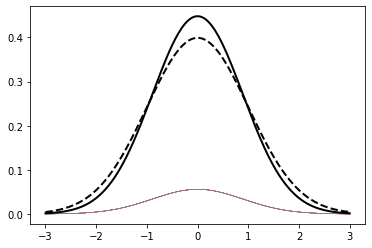

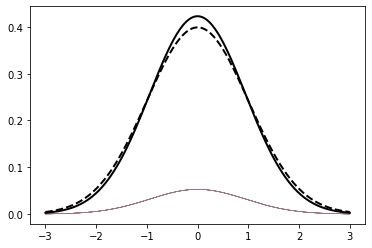

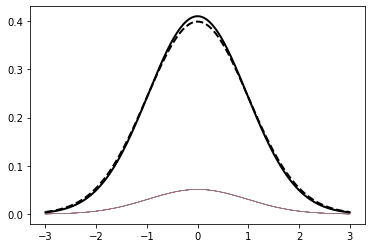

In [105]:
optimizer = optim.Adam(m.parameters(), lr=0.01)
for epoch in range(1000):
    optimizer.zero_grad()
    loss = KL(m.mu,nn.functional.softplus(m.pvar),torch.tensor(0.), torch.tensor(1.)).mean()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'KL loss = {KL(m.mu,nn.functional.softplus(m.pvar),torch.tensor(0.), torch.tensor(1.)).mean()}')
        plt.figure()
        m.plot()